# Creating a Guitar Recommendation Engine using clustering - Part 2

#### Reece Vincent
#### 05/04/2023


## Contents
#### 0 - Data Gathering
- **0.1 Webscraping process**
- **0.2 Webscraping Script**

#### 1 - Data Consolidation
- **1.1 Introduction**
- **1.2 Loading and examining data**
- **1.3 Data consolidation**

#### 2 - EDA and FE
- **2.1. Data Preparation**
- **2.2 EDA**
- **2.3 Feature Engineering**
- **2.3 EDA and FE iteration**

#### 3 - Modelling
- **3.1. Initial Model**
- **3.2 Tuning Hyperparameters**
- **3.3 Recommendation Engine**

#### 4 - Conclusions
- **Conclusions**
- **Appendix**

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re #RegEx for pattern matching

## 2.1 Data preparation

Data cleaning tasks, such as removing duplicates, have already been completed. Additional data cleaning including handling missing values and standardizing data formats is still needed before conducting EDA. Prior to conducting EDA the dataset will be reduced and the actions and reasons behind this will be explained.

In [2]:
## Import csv and head check
df = pd.read_csv('guitar_data_consolidated.csv')
df.head()

,model,body,neck,nut width,fingerboard,radius,scale,frets,nut,bridge,...,plating,scratch plate,neck construction,strap button,body top wood,neck binding,bracing,body back,price,brand
0,Gibson Les Paul Standard 50s Heritage Cherry S...,"Mahogany, Maple (Top)",Mahogany,"1.69""",Rosewood,"12""","24.75""","22, Medium Jumbo",Graph Tech,ABR-1 Tune-O-Matic w/ Stopbar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,£599.00,Gibson
1,PRS SE John Mayer Silver Sky Dragon Fruit,Poplar,Maple,1 20/32”,Rosewood,8.5”,25.5”,22,Synthetic Bone,2-Point Steel Tremolo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,£469.00,PRS
2,Epiphone Les Paul Standard '60s Iced Tea,Mahogany with AA Flame Maple Top,Mahogany,"1.693""",Indian Laurel,"12""","24.75""",22 Medium Jumbo,Graph Tech,LockTone ABR with Stopbar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"£1,399.00",Epiphone
3,Fender Kurt Cobain Jaguar 3 Colour Sunburst NO...,Alder,Maple,"1.65""",Rosewood,"9.5""","24""","22, Medium Jumbo",Synthetic Bone,Black Chrome Adjusto-Matic w/ Chrome Vintage-S...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,£399.00,Fender
4,Epiphone SG Standard Ebony,Mahogany,Mahogany,"1.693""",Indian Laurel,"12""","24.75""",22 Medium Jumbo,Graph Tech,LockTone ABR Tune-o-Matic with Stopbar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"£9,499.00",Epiphone



Examining the data there is an obvious large jump in the null values by feature - 801 for neck shape to 2366 for Unnamed: 13. There are 16 columns with 801 or fewer null values and 86 columns with 2366 or more for 3014 entries. A brief look at some extreme high null columns does show that they could compliment the low nulls if more consolidation was carried out. For example scale length (with 2837 nulls) could compliment and reduce the 425 scale nulls.

Some features are genuinely mostly missing and would not be alleviated by further consolidation (e.g. country of origin has 2996 nulls and no similar columns). As mentioned previously no further consolidation will be taking place so decisions must be made about how to deal with the missing values.





In [3]:
## Null count
nulls = df.isnull().sum()
nulls

model              0
body             217
neck             284
nut width        759
fingerboard      325
                ... 
neck binding    3010
bracing         3011
body back       3011
price              0
brand              0
Length: 102, dtype: int64

In [4]:
## Count the number of columns that have more than 2000 null values
sum(nulls > 2000)

86

In [5]:
## df dimensions
df.shape

(3014, 102)

### Preliminary feature selection

To help inform the decision around nulls it is necessary to recall the aim of the project. The Recommender will be based on clustering guitars into "classes" based on similarity. Although this will be approached as an unsupervised problem some domain knowledge can be applied to group features into different categories:

- **Tone**: wood type, pickups, neck type

- **Playability**:  bridge type, no. of frets, neck shape/size

- **Cosmetic**:     tuners, neck and body finish, colors

- **Other** :   price, brand, controls

The above is only an example and there are other features which may fit in the categories. How a guitar sounds and how it plays are of primary importance when it comes to similarity. Price and brand recognition are also of high importance - if a guitar is in a certain price range a similar guitar would probably be in that price range as well. If you like a model from a particular brand you'll probably like other models from that brand as well.

On the other hand cosmetic features are of secondary importance - most people will take these as considerations after they are decided on what sort of wood they'd like, how many frets the guitar as, how much they'd like to spend etc.

With that in mind and only choosing from the group features that are consolidated (801 or fewer nulls) I decide to focus on the below features for EDA:

In [6]:
## New df from chosen features for eda
features = ['model', 'brand', 'price', 'bridge', 'frets', 'body', 'pickups', 'neck', 'fingerboard', 'scale', 'radius', 'neck shape']
eda_df = df[features]

eda_df.head()

,model,brand,price,bridge,frets,body,pickups,neck,fingerboard,scale,radius,neck shape
0,Gibson Les Paul Standard 50s Heritage Cherry S...,Gibson,£599.00,ABR-1 Tune-O-Matic w/ Stopbar,"22, Medium Jumbo","Mahogany, Maple (Top)","BurstBucker 1 (Neck), BurstBucker 2 (Bridge)",Mahogany,Rosewood,"24.75""","12""",NaN
1,PRS SE John Mayer Silver Sky Dragon Fruit,PRS,£469.00,2-Point Steel Tremolo,22,Poplar,635JM “S” Single-Coil Set,Maple,Rosewood,25.5”,8.5”,635JM
2,Epiphone Les Paul Standard '60s Iced Tea,Epiphone,"£1,399.00",LockTone ABR with Stopbar,22 Medium Jumbo,Mahogany with AA Flame Maple Top,"ProBucker 2 Neck, ProBucker 3 Bridge",Mahogany,Indian Laurel,"24.75""","12""",NaN
3,Fender Kurt Cobain Jaguar 3 Colour Sunburst NO...,Fender,£399.00,Black Chrome Adjusto-Matic w/ Chrome Vintage-S...,"22, Medium Jumbo",Alder,"DiMarzio DP100 Super Distortion (Bridge), DiMa...",Maple,Rosewood,"24""","9.5""","Modern ""C"""
4,Epiphone SG Standard Ebony,Epiphone,"£9,499.00",LockTone ABR Tune-o-Matic with Stopbar,22 Medium Jumbo,Mahogany,Alnico Classic Pro Set,Mahogany,Indian Laurel,"24.75""","12""",60s SlimTaper


Looking at the number of unique values for each of the columns it is apparent that, like data consolidation, imputing nulls will be a time-consuming activity. There will need to be a lot of exploration of trends to find justification for the imputations. In this case it is deemed more effective to put that time into data consolidation to get true values instead of imputing means or modes for example.

Ultimately this is outside the timeframe for this project so for convenience all the rows with at least 1 null entry are dropped. This reduces the data from 3014 entries to 1662. It is important to note that this number could improve when this step is iterated: once features have been explored and chosen for modelling they will be taken from 'df' NOT 'eda_df' and 'df' will be cleaned and prepared. If certain features that have been chosen for 'eda_df' are not used in the modeling process, rows that were dropped due to null values only in those now unselected features will not be dropped in 'df' when 'df' is prepared for modelling. This concept will be illustrated more clearly later on at the end of this notebook in the "Iteration section".

In [7]:
## Print the number of different values for each column
for column in df.columns:
    num_unique = df[column].nunique()
    print(f"Column '{column}' has {num_unique} different values.")



Column 'model' has 3014 different values.
Column 'body' has 515 different values.
Column 'neck' has 324 different values.
Column 'nut width' has 158 different values.
Column 'fingerboard' has 168 different values.
Column 'radius' has 161 different values.
Column 'scale' has 156 different values.
Column 'frets' has 244 different values.
Column 'nut' has 191 different values.
Column 'bridge' has 1045 different values.
Column 'tuners' has 522 different values.
Column 'pickups' has 1301 different values.
Column 'controls' has 937 different values.
Column 'Unnamed: 13' has 334 different values.
Column 'neck shape' has 392 different values.
Column 'fretboard' has 62 different values.
Column 'tuning machines' has 29 different values.
Column 'inlays' has 47 different values.
Column 'pickup' has 24 different values.
Column 'top' has 22 different values.
Column 'binding' has 28 different values.
Column 'fretboard radius' has 16 different values.
Column 'bridge pickup' has 93 different values.
Co

In [8]:
## drop all nulls - when we iterate process we could refine this step. Approx 1.3k rows dropped
eda_df = eda_df.dropna()
eda_df.shape

(1662, 12)

### Data cleaning
To progress with cleaning I examine the columns I want to standardize numerically and understand the changes that are needed. This, along with any other large scale changes, are subsequently implemented in a "cleaner" function after all necessary examination is completed.

In [9]:
## check
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 1 to 3012
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   model        1662 non-null   object
 1   brand        1662 non-null   object
 2   price        1662 non-null   object
 3   bridge       1662 non-null   object
 4   frets        1662 non-null   object
 5   body         1662 non-null   object
 6   pickups      1662 non-null   object
 7   neck         1662 non-null   object
 8   fingerboard  1662 non-null   object
 9   scale        1662 non-null   object
 10  radius       1662 non-null   object
 11  neck shape   1662 non-null   object
dtypes: object(12)
memory usage: 168.8+ KB


For frets I want to extract the first number in each entry and change it into an integer - for example "24, Medium" would change to 24. This will be done using RegEx.

There are ~5 entries that do not represent (e.g "Super Jumbo") that will need to be dropped. Finally, there is one entry "twenty two\r\n" for which is easier to change manually.

In [10]:
## Examine frets value counts
eda_df.frets.value_counts()

22 Medium Jumbo           273
22                        224
21                        104
22 Narrow Tall             75
24                         62
                         ... 
21 Medium Jumbo (6150)      1
twenty two\r\n              1
22 Narrow Tall\r\n          1
22 X Jumbo\r\n              1
21 Medium Vintage           1
Name: frets, Length: 149, dtype: int64

In [11]:
eda_df[eda_df['frets'] == 'twenty two\r\n']

,model,brand,price,bridge,frets,body,pickups,neck,fingerboard,scale,radius,neck shape
2019,Fender Made in Japan Hybrid II Stratocaster US...,Fender,"£1,349.00",2-Point Synchronized Tremolo with Vintage-Styl...,twenty two\r\n,Alder,Hybrid II Custom Voiced Single Coil Stratocast...,Maple,Maple,"25.5"" (64.77cm)\r\n","9.5"" (241mm)\r\n","Modern ""C""\r\n"


Similar to frets 'scale' will be standardized by extracting the first number. In a small number of cases the entries are in a range, they will be assigned the lower boundary of this range.

The 'scale' column has a mixture of measurements, the majority being in inches and some in millimeters. They will all be converted to inches, '"' unit removed and the numbers converted to floats. The same will be done to the 'radius' column.

In [12]:
eda_df.scale.value_counts()

25.5"                         838
24.75"                        287
24.6"                          50
25"                            44
25.5" (648 mm)                 37
                             ... 
25.5”- 27" (648mm-685.8mm)      1
26.5”                           1
25.5”- 27"                      1
24.5"                           1
24.75" (629 mm)\r\n             1
Name: scale, Length: 89, dtype: int64

In [13]:
eda_df.radius.value_counts()

12"                          415
9.5"                         255
7.25"                         75
305mm                         64
14"                           61
                            ... 
300-400mm Compound             1
240mm                          1
228mmR to 305mmR Compound      1
7.25"                          1
  12"                          1
Name: radius, Length: 133, dtype: int64

For price it will be necessary to remove "£" and "," from the strings and convert the remainder into floats. All of these numeric changed will now be carried out:

In [14]:
## Function for converting mm to inches

def converter(x):
    if isinstance(x, str):
        return x  ## Return unchanged string
    elif x > 100:
        return round(x * 0.03937, 1)  ## Multiply numeric values greater than 100 with inch exchange
    else:
        return round(x, 1)  ## Return other numeric values unchanged

In [15]:
## Function that cleans and formats the numeric features

def cleaner(df):

    ## Remove punctuation and make 'price' a float
    df['price'] = df['price'].str.replace('£', '')
    df['price'] = df['price'].str.replace(',', '').astype(float)

    ## Extract first 'scale' values - strings without any numeric characters remain unchanged
    ## converter function applied
    df['scale'] = df['scale'].apply(lambda x: float(re.findall(r'[\d\.]+', str(x))[0]) if re.findall(r'[\d\.]+', str(x)) else x)
    df['scale'] = df['scale'].apply(converter)

    ## Extract first 'radius' value and convert to inches if needed
    ## converter function applied
    df['radius'] = df['radius'].apply(lambda x: float(re.findall(r'[\d\.]+', str(x))[0]) if re.findall(r'[\d\.]+', str(x)) else x)
    df['radius'] = df['radius'].apply(converter)

    ## Extract 'frets' value - first get all numeric values for an entry, then only use the first extract
    ## Again if no numeric characters no action is taken
    df['frets'] = df['frets'].apply(lambda x: [int(d) for d in re.findall('\d+', x)] if re.search('\d+', x) else x)
    df['frets'] = df['frets'].apply(lambda x: x[0] if isinstance(x, list) else x)


## Apply to eda_df
cleaner(eda_df)

After applying the function on 'eda_df' the value counts are examined. For 'frets' and 'radius' we have string values. This is not surprising as these were seen in prior checks and they were left in to illustrate how the function will catch these cases when it's applied to data that hasn't been thoroughly examined yet. For radius there are 4 entries with 'Compound' value and 2 entries with 'Flat'. These will be dropped as no information on their radius values attained from that.

For 'frets' there is a string that can be changed to a number and there are 6 entries for which a numeric value can't be inferred so those are dropped.

In [16]:
eda_df['radius'].value_counts()

12.0        671
9.5         394
7.2         132
10.0        108
13.8         73
14.0         73
15.7         62
20.0         39
16.9         31
16.0         19
9.0          18
11.8          9
9.8           7
Compound      4
12.6          4
15.8          4
11.0          3
8.5           3
15.0          3
7.5           2
Flat          2
9.4           1
Name: radius, dtype: int64

In [17]:
eda_df['frets'].value_counts()

22                                                                      923
24                                                                      410
21                                                                      308
20                                                                       10
27                                                                        3
Super Jumbo                                                               1
twenty two\r\n                                                            1
25                                                                        1
Jumbo Jescar Stainless Steel frets w/j.custom\r\nfret edge treatment      1
Jumbo Jescar EVOgold™ frets w/j.custom\r\nfret\r\nedge treatment          1
Jumbo Jescar EVOgold™ frets w/j.custom fret edge treatment                1
Jumbo Jescar EVOgold™                                                     1
Jumbo\r\n                                                                 1
Name: frets,

In [18]:
eda_df.shape

(1662, 12)

In [19]:
## Change string value to numeric
eda_df.loc[eda_df['frets'] == 'twenty two\r\n', 'frets'] = 22

## Filter rows where 'frets' is numeric and make int
eda_df = eda_df[eda_df['frets'].apply(lambda x: str(x).isnumeric())]
eda_df['frets'] = eda_df['frets'].astype(int)

## Remove 'Flat' and 'Compound' rows and make 'scale' float
eda_df = eda_df[(eda_df['radius'] != 'Flat') & (eda_df['radius'] != 'Compound')]
eda_df['radius'] = eda_df['radius'].astype(float)

eda_df.shape

(1650, 12)

The 12 entries have now been dropped.

In [20]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 1 to 3012
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   model        1650 non-null   object 
 1   brand        1650 non-null   object 
 2   price        1650 non-null   float64
 3   bridge       1650 non-null   object 
 4   frets        1650 non-null   int32  
 5   body         1650 non-null   object 
 6   pickups      1650 non-null   object 
 7   neck         1650 non-null   object 
 8   fingerboard  1650 non-null   object 
 9   scale        1650 non-null   float64
 10  radius       1650 non-null   float64
 11  neck shape   1650 non-null   object 
dtypes: float64(3), int32(1), object(8)
memory usage: 161.1+ KB


## 2.2 EDA

Now the numeric data has been standardised and nulls have been dealt with EDA can commence.

The variance for each numeric feature is calculated, and it is apparent that 'price' a significantly higher variance than the other features. It is also apparent that 'frets' and 'scale' have relatively small values while 'radius' is more moderate. There are still a large number of unique values for the categorical data. Some EDA of these categories has been left until the "Feature Engineering" section where domain knowledge will be used to reduce feature dimensionality.

In [21]:
## Print the number of different values for each column
for column in eda_df.columns:
    num_unique = eda_df[column].nunique()
    print(f"Column '{column}' has {num_unique} different values.")

Column 'model' has 1650 different values.
Column 'brand' has 48 different values.
Column 'price' has 276 different values.
Column 'bridge' has 575 different values.
Column 'frets' has 6 different values.
Column 'body' has 280 different values.
Column 'pickups' has 773 different values.
Column 'neck' has 175 different values.
Column 'fingerboard' has 96 different values.
Column 'scale' has 19 different values.
Column 'radius' has 20 different values.
Column 'neck shape' has 296 different values.


In [22]:
## Summary stats
eda_df.describe()

,price,frets,scale,radius
count,1650.000000,1650.000000,1650.000000,1650.000000
mean,1976.164824,22.301818,25.289697,11.469879
std,1800.228717,1.072761,0.488984,2.542645
min,79.000000,20.000000,22.200000,7.200000
25%,679.000000,22.000000,24.800000,9.500000
50%,1329.000000,22.000000,25.500000,12.000000
75%,2699.000000,22.000000,25.500000,12.000000
max,13999.000000,27.000000,29.800000,20.000000


In [23]:
## Calculate variance of each feature
variance = eda_df.var()
print(variance)

price     3.240823e+06
frets     1.150815e+00
scale     2.391054e-01
radius    6.465041e+00
dtype: float64


C:\Users\gabri\AppData\Local\Temp\ipykernel_2692\868626919.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = eda_df.var()


### Displots

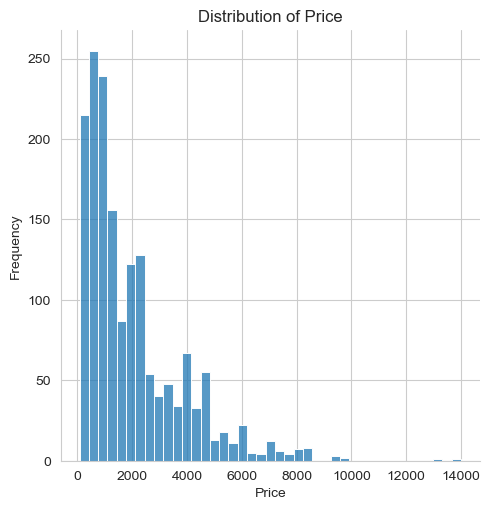

In [24]:
## Plot displot for 'price
sns.displot(data=eda_df, x='price')

## Set plot title and axis labels
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

## Show the plot
plt.show()

There is a clear right skew to the 'price' distribution. A log transform makes this more normally distributed.

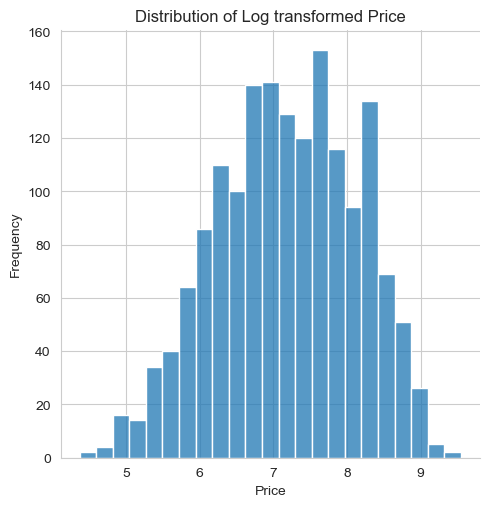

In [25]:
## Create log transform plot
sns.displot(data=eda_df, x=np.log(eda_df["price"]))

## Set plot title and axis labels
plt.title('Distribution of Log transformed Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

## Show the plot
plt.show()

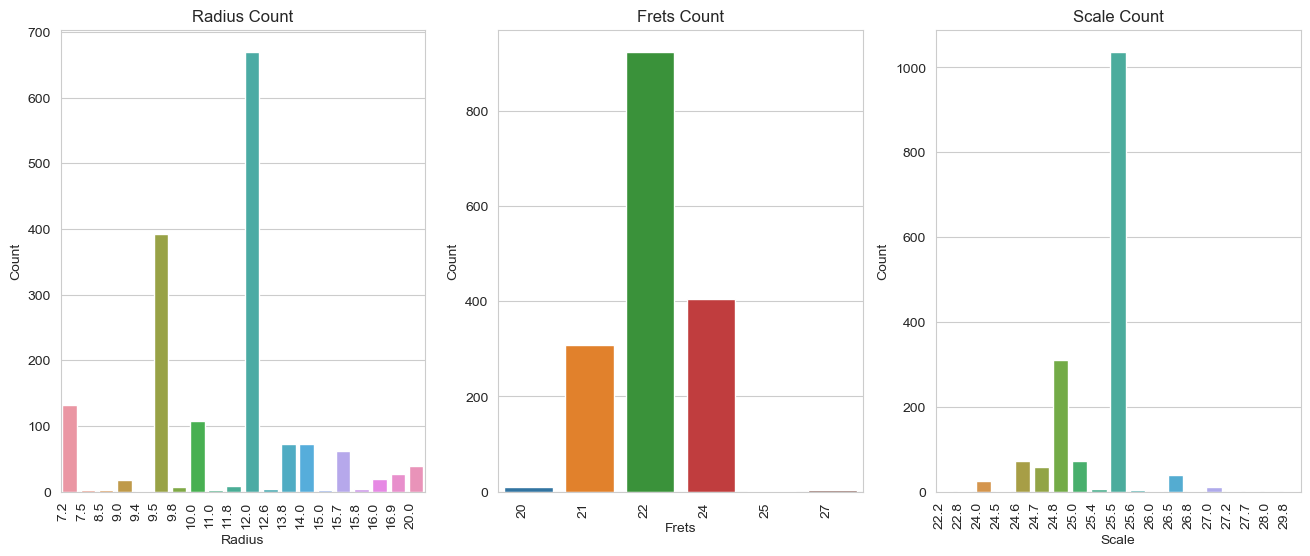

In [26]:
# Create 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot countplot for 'radius' on the first subplot
sns.countplot(data=eda_df, x='radius', ax=axes[0])
axes[0].set_title('Radius Count')
axes[0].set_xlabel('Radius')
axes[0].set_ylabel('Count')

# Plot countplot for 'frets' on the second subplot
sns.countplot(data=eda_df, x='frets', ax=axes[1])
axes[1].set_title('Frets Count')
axes[1].set_xlabel('Frets')
axes[1].set_ylabel('Count')

# Plot countplot for 'scale' on the third subplot
sns.countplot(data=eda_df, x='scale', ax=axes[2])
axes[2].set_title('Scale Count')
axes[2].set_xlabel('Scale')
axes[2].set_ylabel('Count')

# Rotate x-axis tick labels for all subplots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Show the plot
plt.show()




Radius shows a large decline with 12.0 on ~650, 9.5 on ~390, 7.2 on ~ 120 and then a more staggered decline.

It is shown that for Frets value 22 is by far the most common with 21 and 24 being next on less than half the values. The other value counts are minimal.

A similar story emerges for Scale results with 25.5 extremely common with over 1000 counts and 24.8 in 2nd place on roughly 350.

### Pairplot

Looking at the Pairplot and correlation matrix for for the data it is apparent that there is little correlation between features except Frets and Radius having a positive correlation.

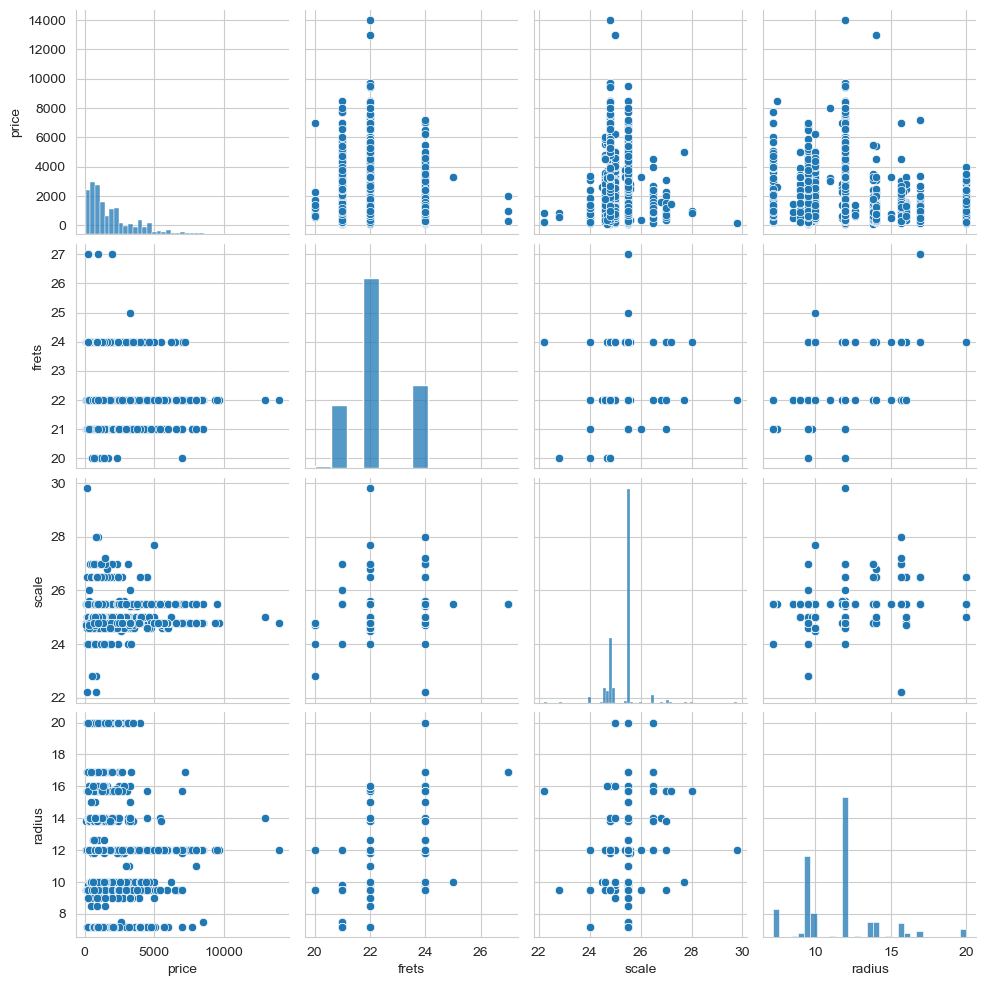

In [27]:
sns.pairplot(eda_df)
plt.show()

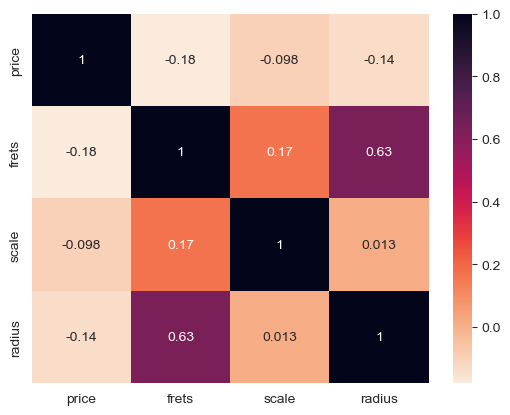

In [28]:
sns.heatmap(eda_df.corr(),
            annot=True,
            cmap='rocket_r')
plt.show()

### Countplots

For brands Fender is the clear front-runner which isn't surprising due to the popularity of this brand. It is interesting to note however that it is by twice the amount of second placed Ibanez. Generally though the more well known brands do seem to be at the higher end of this distribution and as it tapers the brands are more obscure/specialist.

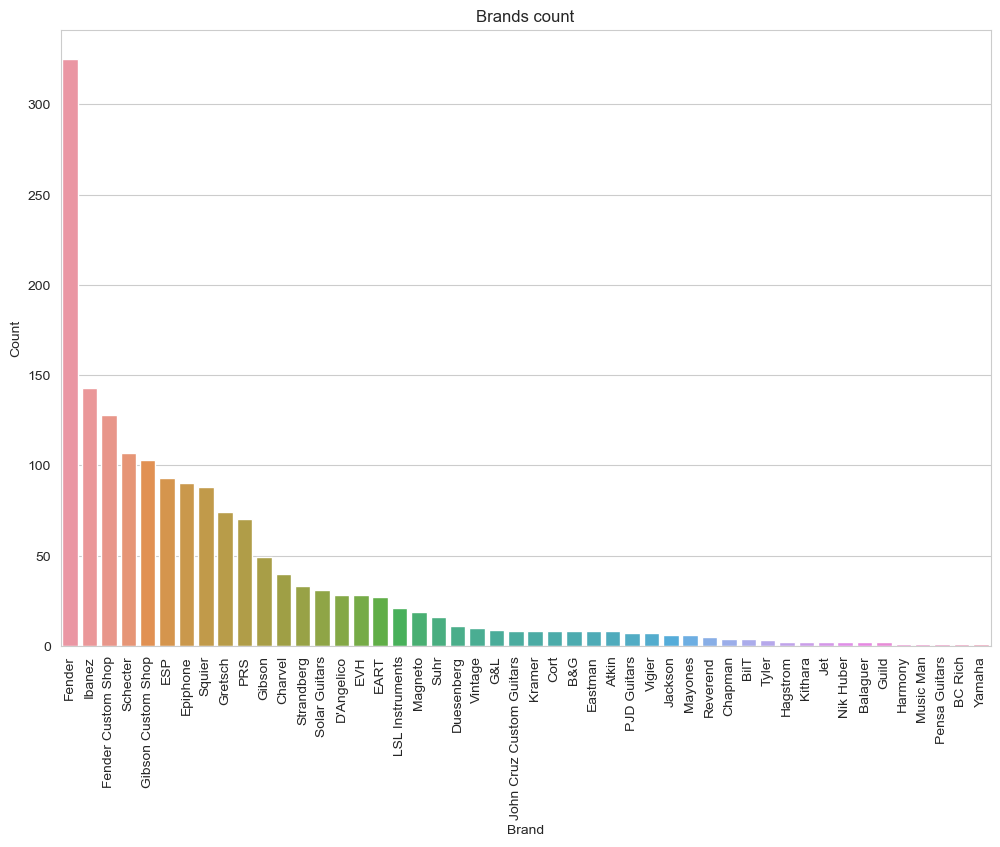

In [29]:
# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the countplot with the 'brand' column
sns.countplot(x='brand', data=eda_df, order=eda_df['brand'].value_counts().index, ax=ax)

## Set plot title and axis labels
plt.title('Brands count')
plt.xlabel('Brand')
plt.ylabel('Count')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

Looking at Brands vs Price there is a huge amount of variance. Price and Brand will likely be important features to keep for modelling due to this large amount of variance.

Interestingly we see the medians grouped into a higher and lower group. For example Custom shops brands have a much higher median than most other brands which is to be expected as these are more bespoke models. The majority of brands have the same lower IQR value which implies that they all have similarly priced entry level guitars.

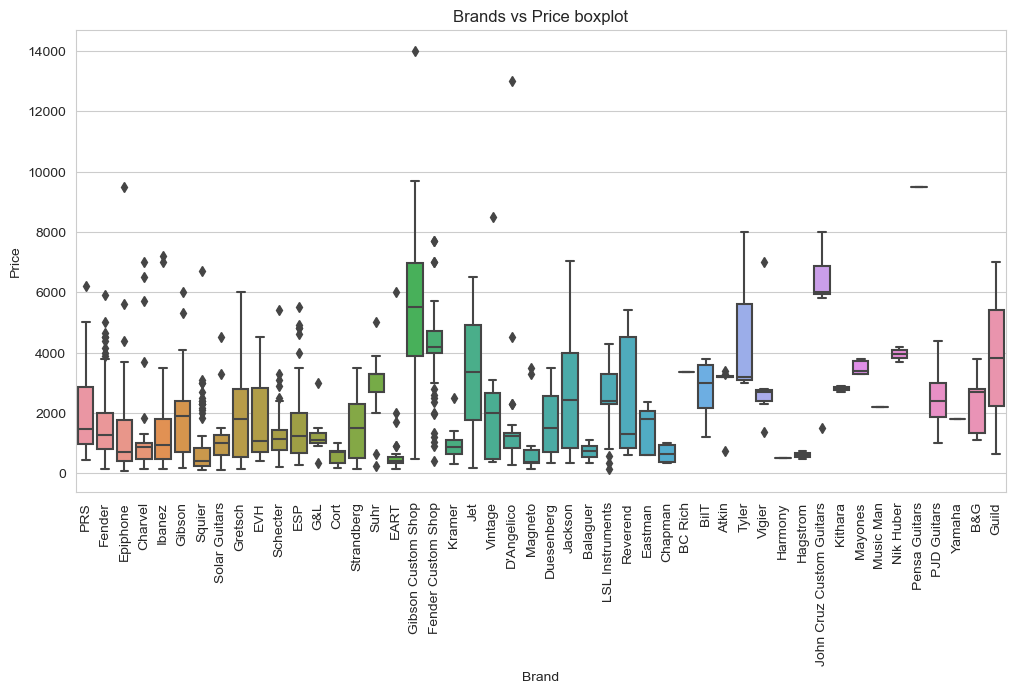

In [30]:
# Set the figure size
plt.figure(figsize=(12, 6)) # Set the figure size

# Create the box plot
sns.boxplot(x='brand', y='price', data=eda_df)

## Set plot title and axis labels
plt.title('Brands vs Price boxplot')
plt.xlabel('Brand')
plt.ylabel('Price')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

## 2.3 Feature Engineering

### Categorising data
Before modelling FE is required. I'll begin by exploring some categorical variables.

Firstly I will start with 'bridge' as I believe this may be a useful feature for similarity and I also know that fundamentally it can be broken down into 3-6 "types" of guitar bridge. The three main ones are "Tune-O-matic", "Tremolo" and "Hardtail". Bridge types can have an impact on both playability and tone so they are an important festure when it comes to similarity.

In [31]:
## Recall how many values there are
eda_df.bridge.nunique()

575

In [32]:
## View value counts
eda_df.bridge.value_counts()

Custom Shop Vintage Synchronized Tremolo                    48
2-Point Synchronized Tremolo with Bent Steel Saddles        37
2-Point Synchronized Tremolo with Block Saddles             30
ABR-1 with Lightweight Aluminium Stopbar Tailpiece          26
2 Point Synchronised Tremolo with Bent Steel Saddles        22
                                                            ..
LTD Fixed Bridge With String Thru                            1
3-Saddle Vintage Style Tele® with Threaded Steel Saddles     1
ABR-1 Single Diamond Trapeze with Trini Lopez Insert         1
Anchored Adjusto-Matic with Bigsby Licensed B70 Vibrato      1
3-Saddle Vintage-Style Tele with Slotted Steel Saddles       1
Name: bridge, Length: 575, dtype: int64

Looking through the unique values I've chosen to bin the bridge types into 6 categories. I have chosen to do this by looking for terms in each value and assigning it to one of the categories using that value.

Overall this has been done fairly rigorously and there shouldn't be many errors but it is important to remember some may get misassigned. It's also important to remember that there may be some edge cases that do not strictly belong in one category, yet they will be assigned to just one.

The 6 Categories are:
- **"TOM"** (Tune-o-matic)
- **"Tremolo"**
- **"Hardtail"**
- **"Wraparound"**
- **"Evertune"**
- **"Monorail"**

In [33]:
## BIN bridge types into supersets

toms = ['TUNE-O-MATIC', 'TUNEOMATIC', 'NASHVILLE', 'TOM', 'ABR', 'ABR-1', 'ADJUSTO-MATIC', 'TONEPROS', 'TONE PROS', 'TONE-PROS', 'GE103B', 'GE-103B', 'ASHTRAY', 'ADJUSTO-MATIC', 'ADJUSTABLE RADIUS', 'FULLY ADJUSTABLE', 'ADJUSTO']
three = ['3-SADDLE', '3 SADDLE']
ht = ['HARDTAIL', 'HARD TAIL', '6-SADDLE STRING', '6 SADDLE STRING', 'SIX SADDLE', 'FIXED', 'TELE BRIDGE', '6-SADDLE', '6 SADDLE', 'HIPSHOT', 'MONO-TUNE', 'MONO TUNE', 'MONOTUNE', 'SADDLE', 'TWO PIECE', 'TWO-PIECE', '2 PIECE', '2-PIECE', 'F106', 'VINTAGE', 'STOPTAIL', 'GIBRALTAR', 'EDGEZERO', 'EDGE-ZERO', 'EDGE ZERO', 'EDGE', 'T1702B', 'GTC202','T1572S', 'T1802', 'F1803', '510BN', 'PT-H', 'ART-ST', 'TRADITIONAL FLAT MOUNT', 'CHOPPED CLASSIC T', 'TRU ARC BRASS', 'COMPENSATED ALUMINIUM', 'PRS PLATE STYLE', 'F108', 'EBONY JIMMY', 'EBONY WITH GB10', 'WALNUT', 'ADJUSTABLE EBONY', 'OVANGKOL', 'MTB HT6', 'G2TS', 'ART-12'] ## ht/fixed bridge
trem = ['TREM', 'FLOYD ROSE', 'ROCKING BAR', 'VIBR', 'LO-PRO', 'LO PRO', 'FINETUNER', 'FINE TUNER', 'FINE-TUNER', 'T1872S', 'GOTOH 510', 'EGS', 'SPACE CONTROL', 'SYNCHRO-SONIC', 'IBANEZ FULL TUNE III', 'BIGSBY B-50', 'JACKSON MTB HT6', 'SCHALLER HANNES', 'BIGSBY B-5', 'ABM AVR-2 & ALUMINIUM TAILPIECE, NICKEL AGED'] ## vibrato/tremolo/FR
wrap = ['WRAPAROUND', 'WRAP-AROUND', 'WRAP AROUND']
et = ['EVERTUNE']

mono = ['MONORAIL', 'MONO-RAIL']

eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(toms)), 'bridge'] = 'TOM'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(trem)), 'bridge'] = 'tremolo'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(three)), 'bridge'] = '3-saddle'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(ht)), 'bridge'] = 'hardtail'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(wrap)), 'bridge'] = 'wraparound'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(et)), 'bridge'] = 'evertune'
eda_df.loc[eda_df['bridge'].str.upper().str.contains('|'.join(mono)), 'bridge'] = 'monorail'

In [34]:
eda_df['bridge'].value_counts()

tremolo                                                                  645
TOM                                                                      525
hardtail                                                                 419
wraparound                                                                26
evertune                                                                  23
monorail                                                                  10
Master Volume, Tone 1. (Neck/Middle Pickups), Tone 2. (Bridge Pickup)      1
F107                                                                       1
Name: bridge, dtype: int64

In [35]:
## This should be a tremelo bridge
eda_df[eda_df['bridge'] == 'Master Volume, Tone 1. (Neck/Middle Pickups), Tone 2. (Bridge Pickup)']

,model,brand,price,bridge,frets,body,pickups,neck,fingerboard,scale,radius,neck shape
55,Squier Affinity HSS Stratocaster Pack Charcoal...,Squier,2169.0,"Master Volume, Tone 1. (Neck/Middle Pickups), ...",21,Poplar,Bridge: Ceramic Humbucker\r\nMiddle: Ceramic S...,Maple,Indian Laurel,25.5,9.5,"""C"""


In [36]:
## Change value
eda_df.loc[eda_df['bridge'] == 'Master Volume, Tone 1. (Neck/Middle Pickups), Tone 2. (Bridge Pickup)', 'bridge'] = 'tremolo'

In [37]:
## Bridge value F107 could not be determined so this row is dropped
eda_df = eda_df[eda_df['bridge'] != 'F107']

In [38]:
eda_df['bridge'].value_counts()

tremolo       646
TOM           525
hardtail      419
wraparound     26
evertune       23
monorail       10
Name: bridge, dtype: int64

575 bridge values have been categorised into 6 categories, with the vast majority being in 3 of these categories. This is illustrated in the plot below.

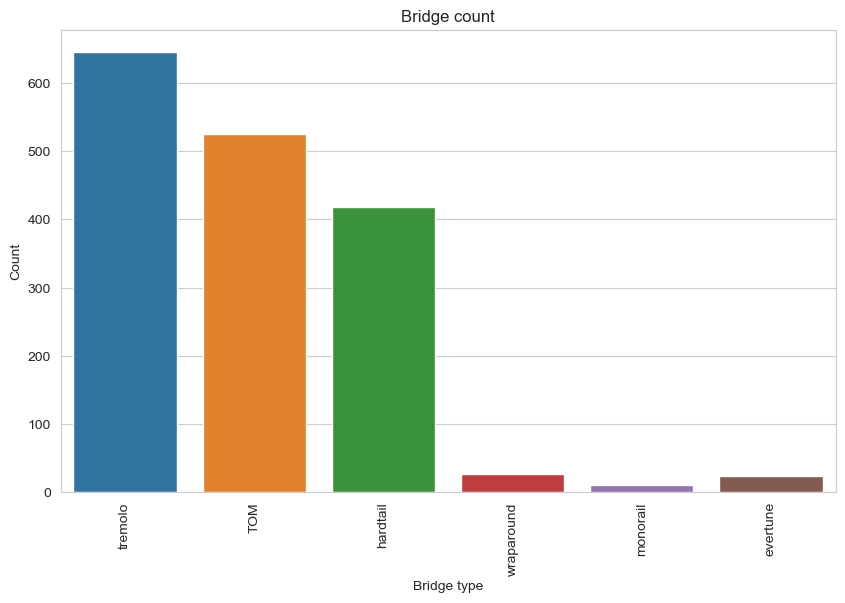

In [39]:
## Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

## Create the countplot with the 'brand' column
sns.countplot(x='bridge', data=eda_df)

## Set plot title and axis labels
plt.title('Bridge count')
plt.xlabel('Bridge type')
plt.ylabel('Count')

## Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

## Show the plot
plt.show()

Neck shape is now looked at in more detail. It has 296 unique values. Ultimately they can be categorised into four main types:
- **C Shape**
- **V Shape**
- **D Shape**
- **U Shape**

There are limitations to this approach. Firstly, some guitar neck shapes will be a hybrid style of 2 of the shapes. This information will be lost when they are binned into the four categories. There are also different types within one shape - there can be slim/taper builds, thicker builds and asymmetrical builds to name a few. This added layer of info will also be lost. On balance, I believe the informational loss vs the time needed to fine-tune the binning process is an acceptable trade-off for the purpose of this project.

In [40]:
eda_df['neck shape'].nunique()

296

In [41]:
eda_df['neck shape'].value_counts()

"C"                                         87
Thin U                                      79
Modern C                                    74
Deep "C"                                    51
Rounded C                                   41
                                            ..
Authentic '68 Medium "C"                     1
Vintage "C"                                  1
Thin D                                       1
Asymetrical Slim Taper w/ Contoured Heel     1
SlimTaper D                                  1
Name: neck shape, Length: 296, dtype: int64

In [42]:
## BIN bridge types into supersets

C = ['C', '"C"']
D = ['D', '"D"']
U = ['U', '"U"']
V = ['V', '"V"']


eda_df.loc[eda_df['neck shape'].str.upper().str.contains('|'.join(C)), 'neck shape'] = 'C'
eda_df.loc[eda_df['neck shape'].str.upper().str.contains('|'.join(D)), 'neck shape'] = 'D'
eda_df.loc[eda_df['neck shape'].str.upper().str.contains('|'.join(U)), 'neck shape'] = 'U'
eda_df.loc[eda_df['neck shape'].str.upper().str.contains('|'.join(V)), 'neck shape'] = 'V'

In [43]:
eda_df['neck shape'].value_counts()

C                                1018
D                                 215
U                                 164
V                                 106
SlimTaper                          16
Pattern Thin                       13
635JM                              10
60s SlimTaper                      10
Slim Taper                         10
GRX                                 8
Wolfgang Profile                    8
1960 Slim Taper                     7
Pattern                             7
JS                                  5
1960 SlimTaper                      5
635JM-R                             5
Slim                                4
AM Expressionist                    4
GRG                                 4
GRGA                                3
SlimTaper\r\n                       2
Nitro Baritone                      2
AF Expressionist                    2
60s Slim Taper                      2
SA                                  2
AZES                                1
FTM         

) missing from current font.\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


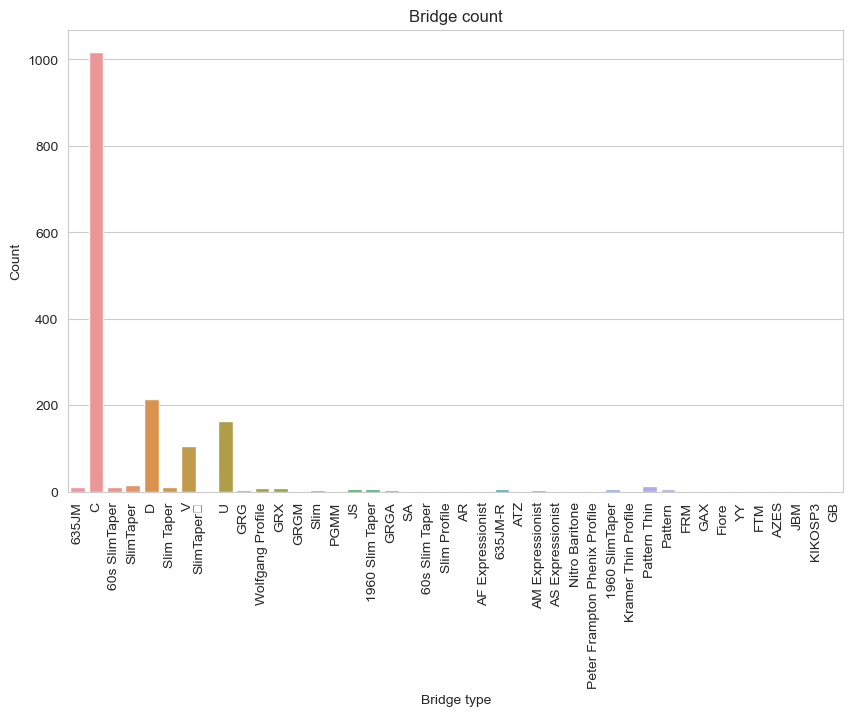

In [44]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Create the countplot with the 'brand' column
sns.countplot(x='neck shape', data=eda_df)

## Set plot title and axis labels
plt.title('Bridge count')
plt.xlabel('Bridge type')
plt.ylabel('Count')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

The "C" shape dominates the values with there being an order of magnitude difference between it and the "D", "U", and "V" types. After binning there are still 42 unique values remaining. Remembering that the idea behind the recommender engine is to use DBSCAN to define guitar "classes" then having many unique values with low values count may not be optimal and may make the data too granular.

Ultimately more time is needed to process this data correctly. Therefore, I decide to drop this feature and make a trade between losing a feature as opposed to losing data entries. In the appendix section there can be found attempts at applying this FE approach to the other features from eda_df. However, due to the timeline of this project, I was unable to fully explore and analyze these features to the extent that was desired, and I was unable to include them in the final analysis. If the reader is interested in these ideas please do refer to the appendix.

### Numeric data
The numerical data has already been examined and formatted in the EDA section. The only additional changes to it will be scaling which will be done when the model is "Part 3" of this project.

## 2.4 EDA and FE iteration

The final features have now been decided and a dataframe for modelling can now be created. To do this I use the original guitar data and iterate the whole process above. The reason for this being that some of the original data entries may have been dropped as they had nulls in features that were initially considered for modelling but now will not be used.

Taking this into account and iterating the process for only features being used means there will be 2065 entries to use in modelling instead of 1649. The EDA findings are unchanged and changes in summary stats such as standard deviation and variance are neglible. As the trends remain unchanged and only minor adjustments are needed to ensure consistent formatting comments for the below code are mostly omitted.

After ths iteration the dataframe is exported as a CSV file.

In [45]:
## amount of entries there would have been
eda_df.shape

(1649, 12)

In [46]:
## Create a copy of df for modelling
mod_df = pd.read_csv('guitar_data_consolidated.csv')

In [47]:
mod_df.shape

(3014, 102)

In [48]:
features = ['model', 'brand', 'price', 'bridge', 'frets', 'scale', 'radius']
mod_df = mod_df[features]

In [49]:
mod_df = mod_df.dropna()
mod_df.shape

(2104, 7)

In [50]:
mod_df[mod_df['frets'] == 'twenty two\r\n']
cleaner(mod_df)
mod_df.shape

(2104, 7)

In [51]:
mod_df['radius'].value_counts()

12.0                 922
9.5                  406
10.0                 138
7.2                  133
14.0                  82
13.8                  78
15.7                  66
16.0                  56
13.0                  43
20.0                  41
16.9                  31
15.0                  21
9.0                   18
9.8                   14
Compound              13
11.8                   9
15.8                   8
12.6                   5
18.0                   5
11.0                   5
8.5                    3
7.5                    2
9.4                    2
Flat                   2
"Infinity" Radius      1
Name: radius, dtype: int64

In [52]:
mod_df['frets'].value_counts()

22                                                                      1186
24                                                                       555
21                                                                       330
20                                                                        11
Medium Jumbo\r\n                                                           4
18                                                                         3
27                                                                         3
47104                                                                      3
Super Jumbo                                                                1
twenty two\r\n                                                             1
25                                                                         1
Jumbo Jescar Stainless Steel frets w/j.custom\r\nfret edge treatment       1
Jumbo Jescar EVOgold™ frets w/j.custom\r\nfret\r\nedge treatment           1

In [53]:
## Change string value to numeric
mod_df.loc[mod_df['frets'] == 'twenty two\r\n', 'frets'] = 22

## Filter rows where 'frets' is numeric and make int, drop fret entry of 47104
mod_df = mod_df[mod_df['frets'].apply(lambda x: str(x).isnumeric())]
mod_df['frets'] = mod_df['frets'].astype(int)
mod_df = mod_df[mod_df['frets'] < 47104]

## Remove 'Flat' and 'Compound' rows and make 'scale' float
mod_df = mod_df[(mod_df['radius'] != 'Flat') & (mod_df['radius'] != 'Compound') & (mod_df['radius'] !='"Infinity" Radius')]
mod_df['radius'] = mod_df['radius'].astype(float)

mod_df.shape

(2074, 7)

In [54]:
mod_df['radius'].value_counts()

12.0    914
9.5     405
10.0    138
7.2     133
14.0     82
13.8     78
15.7     65
16.0     56
13.0     43
20.0     41
16.9     27
15.0     21
9.0      18
9.8      14
11.8      9
15.8      8
12.6      5
18.0      5
11.0      5
8.5       3
7.5       2
9.4       2
Name: radius, dtype: int64

In [55]:
mod_df['frets'].value_counts()

22    1183
24     543
21     330
20      11
18       3
27       3
25       1
Name: frets, dtype: int64

In [56]:
features = ['model', 'brand', 'price', 'bridge', 'frets', 'scale', 'radius']
mod_df = mod_df[features]

In [57]:
## Summary stats
mod_df.describe()

,price,frets,scale,radius
count,2074.000000,2074.000000,2074.000000,2074.000000
mean,1896.295545,22.356798,25.270347,11.689200
std,1746.080347,1.079111,0.507819,2.449813
min,79.000000,18.000000,22.200000,7.200000
25%,651.500000,22.000000,24.800000,9.500000
50%,1289.000000,22.000000,25.500000,12.000000
75%,2499.000000,24.000000,25.500000,12.000000
max,13999.000000,27.000000,29.800000,20.000000


In [58]:
## Calculate variance of each feature
variance = mod_df.var()
print(variance)

price     3.048797e+06
frets     1.164481e+00
scale     2.578805e-01
radius    6.001581e+00
dtype: float64


C:\Users\gabri\AppData\Local\Temp\ipykernel_2692\4040140622.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = mod_df.var()


In [59]:
### Displots

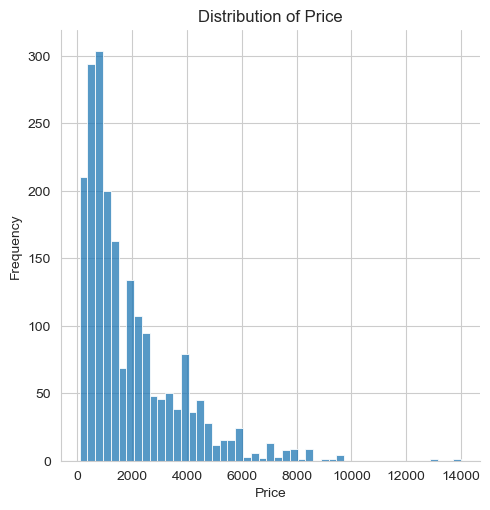

In [60]:
## Plot displot for 'price
sns.displot(data=mod_df, x='price')

## Set plot title and axis labels
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

## Show the plot
plt.show()

There is a
clear
right
skew
to
the
'price'
distribution.A
log
transform
makes
this
more
normally
distributed.

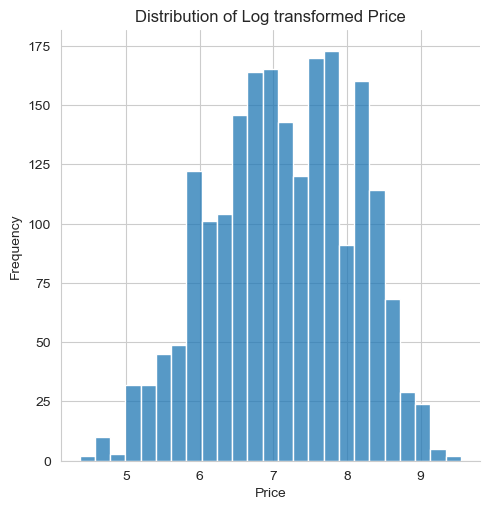

In [61]:
## Create log transform plot
sns.displot(data=mod_df, x=np.log(mod_df["price"]))

## Set plot title and axis labels
plt.title('Distribution of Log transformed Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

## Show the plot
plt.show()

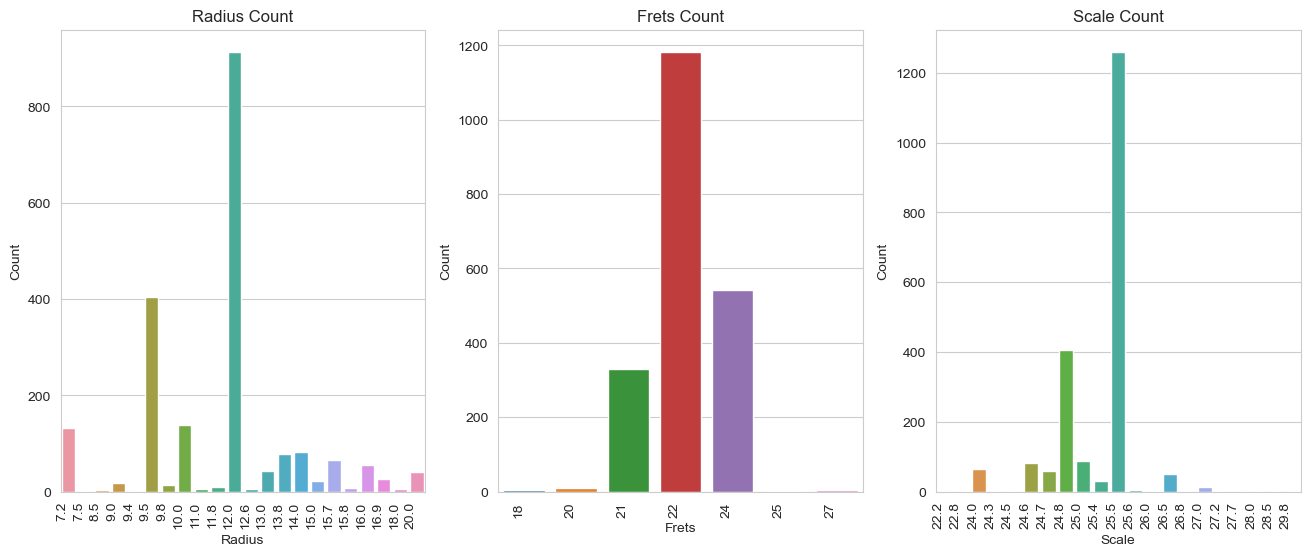

In [62]:
# Create 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot countplot for 'radius' on the first subplot
sns.countplot(data=mod_df, x='radius', ax=axes[0])
axes[0].set_title('Radius Count')
axes[0].set_xlabel('Radius')
axes[0].set_ylabel('Count')

# Plot countplot for 'frets' on the second subplot
sns.countplot(data=mod_df, x='frets', ax=axes[1])
axes[1].set_title('Frets Count')
axes[1].set_xlabel('Frets')
axes[1].set_ylabel('Count')

# Plot countplot for 'scale' on the third subplot
sns.countplot(data=mod_df, x='scale', ax=axes[2])
axes[2].set_title('Scale Count')
axes[2].set_xlabel('Scale')
axes[2].set_ylabel('Count')

# Rotate x-axis tick labels for all subplots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Show the plot
plt.show()

### Pairplot

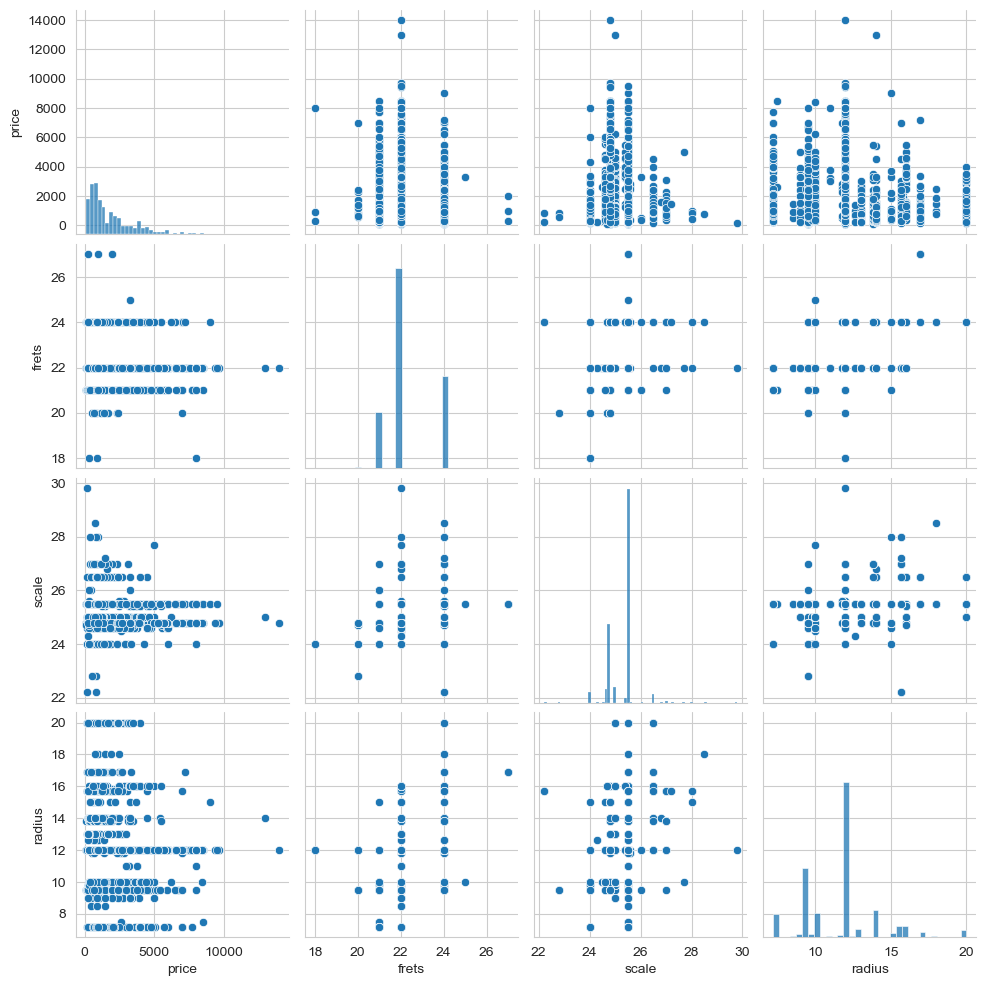

In [63]:
sns.pairplot(mod_df)
plt.show()

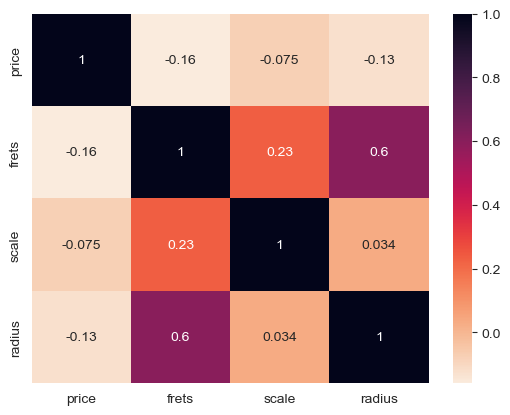

In [64]:
sns.heatmap(mod_df.corr(),
            annot=True,
            cmap='rocket_r')
plt.show()

In [65]:
### Countplots
For
brands
Fender is the
clear
front - runner
which
isn
't surprising due to the popularity of this brand. It is interesting to note however that it is by twice the amount of second placed Ibanez. Generally though the more well known brands do seem to be at the higher end of this distribution and as it tapers the brands are more obscure/specialist.

SyntaxError: EOL while scanning string literal (3282764267.py, line 9)

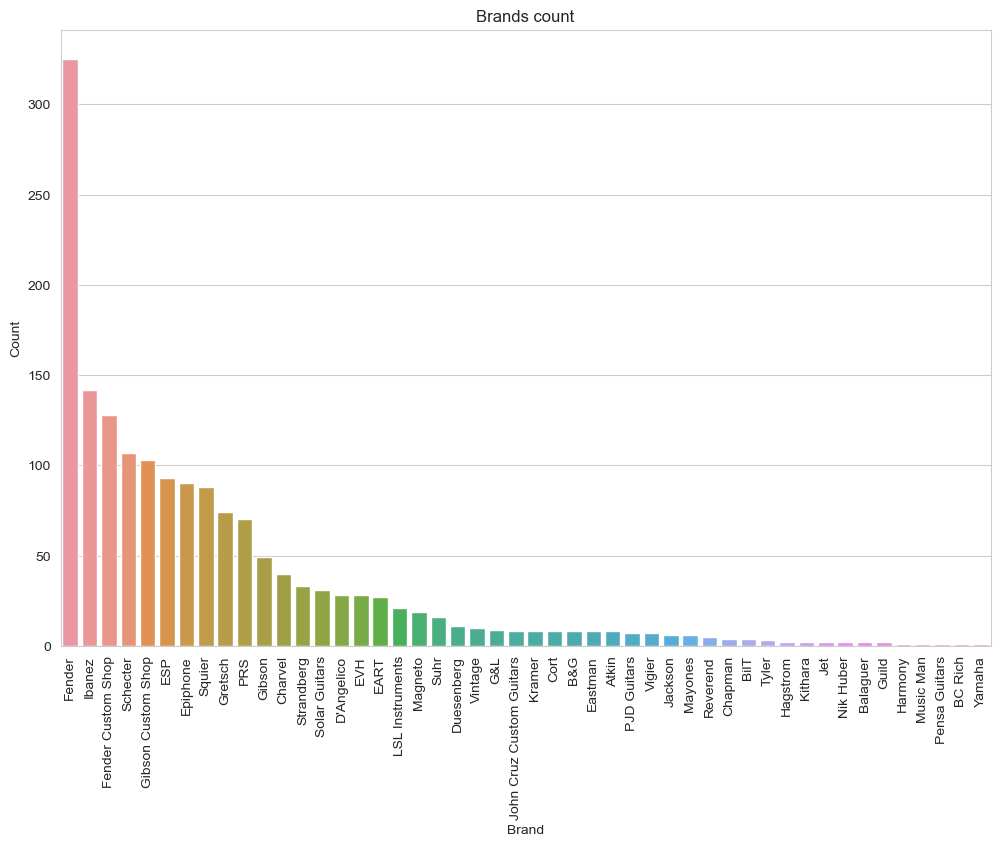

In [66]:
# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the countplot with the 'brand' column
sns.countplot(x='brand', data=eda_df, order=eda_df['brand'].value_counts().index, ax=ax)

## Set plot title and axis labels
plt.title('Brands count')
plt.xlabel('Brand')
plt.ylabel('Count')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

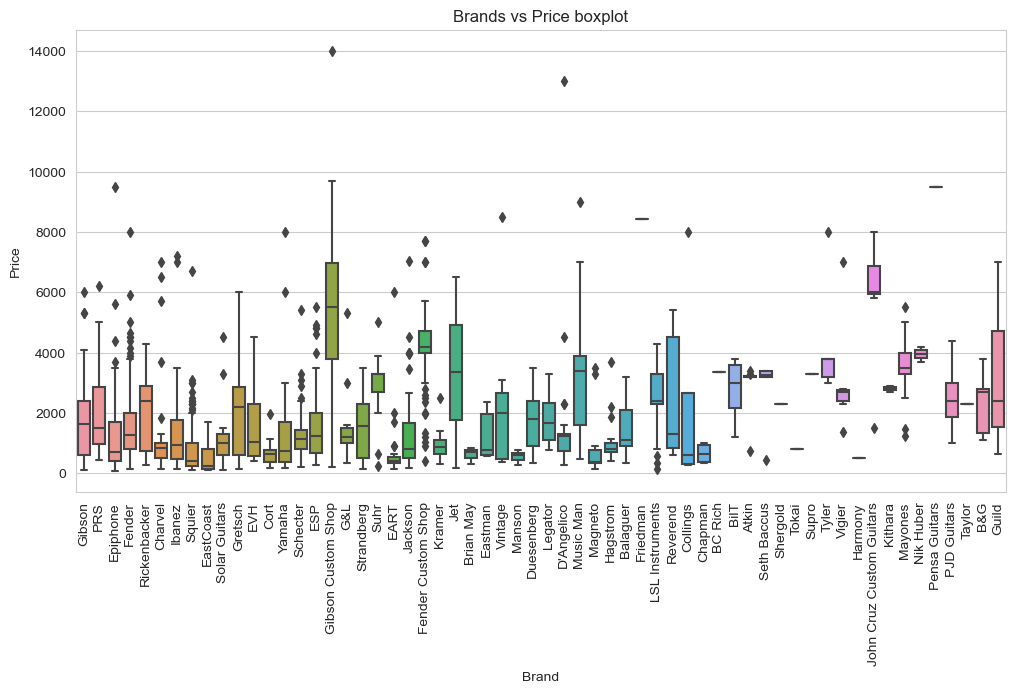

In [67]:
# Set the figure size
plt.figure(figsize=(12, 6))  # Set the figure size

# Create the box plot
sns.boxplot(x='brand', y='price', data=mod_df)

## Set plot title and axis labels
plt.title('Brands vs Price boxplot')
plt.xlabel('Brand')
plt.ylabel('Price')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [68]:
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(toms)), 'bridge'] = 'TOM'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(trem)), 'bridge'] = 'tremolo'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(three)), 'bridge'] = '3-saddle'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(ht)), 'bridge'] = 'hardtail'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(wrap)), 'bridge'] = 'wraparound'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(et)), 'bridge'] = 'evertune'
mod_df.loc[mod_df['bridge'].str.upper().str.contains('|'.join(mono)), 'bridge'] = 'monorail'
mod_df['bridge'].value_counts()

tremolo                                                                  832
TOM                                                                      676
hardtail                                                                 495
wraparound                                                                26
evertune                                                                  26
monorail                                                                  10
Legator Ghost Locking Bridge + Nut\r\n                                     2
Master Volume, Tone 1. (Neck/Middle Pickups), Tone 2. (Bridge Pickup)      1
F107                                                                       1
Legator Ghost Exclusive Locking                                            1
Wave Tailpiece                                                             1
Ebony with Trapeze Style Tailpiece                                         1
Gretsch "G" tailpiece\r\n                                                  1

In [69]:
mod_df.head()

,model,brand,price,bridge,frets,scale,radius
0,Gibson Les Paul Standard 50s Heritage Cherry S...,Gibson,599.0,TOM,22,24.8,12.0
1,PRS SE John Mayer Silver Sky Dragon Fruit,PRS,469.0,tremolo,22,25.5,8.5
2,Epiphone Les Paul Standard '60s Iced Tea,Epiphone,1399.0,TOM,22,24.8,12.0
3,Fender Kurt Cobain Jaguar 3 Colour Sunburst NO...,Fender,399.0,TOM,22,24.0,9.5
4,Epiphone SG Standard Ebony,Epiphone,9499.0,TOM,22,24.8,12.0


In [70]:
mod_df = mod_df[(mod_df['bridge'] == 'tremolo') | (mod_df['bridge'] == 'TOM') | (mod_df['bridge'] == 'hardtail') | (mod_df['bridge'] == 'wraparound') | (mod_df['bridge'] == 'evertune') | (mod_df['bridge'] == 'monorail')]
mod_df['bridge'].value_counts()

tremolo       832
TOM           676
hardtail      495
wraparound     26
evertune       26
monorail       10
Name: bridge, dtype: int64

### Export data

In [71]:
mod_df.shape

(2065, 7)

In [72]:
mod_df.to_csv('guitars_modelling_data.csv', index=False)